# Multi-stop route optimization  

This notebook tackles  the "traveling salesman problem", i.e., the question of how to plan a multi-stop trip in such a way as to minimize overall travel time. Simply comparing all possible travel sequence combinations in a "brute force" fashion runs into rapidly escalating numbers. If we wanted to find the optimal route for only 30 stops, we would find there are 265,252,859,999,999,968,616,720,328,488,440* combinations (i.e., the result of 30!). The dynamic programming solution alluded to in the cartoon below would still come to 30^2x2^30 options to consider, which computes as 966,367,641,600 (i.e., close to a trillion steps).


<img src='images/travelling_salesman_problem.png' width='750' height='600'/>

Source: https://xkcd.com/399/

### Approach <a class="tocSkip">

Instead of using brute force, dynamic programming, or having ebay solve this problem for us, this notebook attempts to use a **genetic algorithm** to tackle the traveling salesman problem. This means randomly generating travel routes and then non-randomly selecting the fastest solutions as "parents" for a next generation of routes. Route subsegments of two "parents" can be recombined to create a "child". Many children created thusly constitute the next generation of routes which can again be selected for the fastest. In an iterative fashion, the route solutions become better as the algorithm cycles through generation after generation of routes. 

However, in order to be able to compare the travel time for any two routes, we first need a **model that can estimate the travel time between any given two points.** This notebook will use a gradient boosted decision tree to do so. This will be done for the greater New York City / New Jersey area based on combined taxi and weather data. 

### Results <a class="tocSkip">

The **travel time estimator** achieves a Mean Absolute Error (MAE) of c. 160 seconds, i.e., it is on average 2:40 minutes wrong when estimating the travel time between any two points in the NYC/NJ area. This could probably be further improved by cleaning the data more diligently, however, this level of imprecision is likely not going to have a major impact on the optimal travel route. 

The **routing algorithm** requires c. 5-10 minutes to find a stable solution for a fast route of 30 destinations (with some room for improvement - see section on "Potential improvements" at the end of this notebook).

<br/>
<br/>



**For all numerophiles, this number spells out as "two hundred sixty-five nonillion, two hundred fifty-two octillion, eight hundred fifty-nine septillion, nine hundred ninety-nine sextillion, nine hundred ninety-nine quintillion, nine hundred sixty-eight quadrillion, six hundred sixteen trillion, 
seven hundred twenty billion, three hundred twenty-eight million, four hundred eighty-eight thousand, four hundred forty"* 



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Building-a-point-to-point-travel-time-estimator" data-toc-modified-id="Building-a-point-to-point-travel-time-estimator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building a point-to-point travel time estimator</a></span><ul class="toc-item"><li><span><a href="#Importing-New-York-City-taxi-data" data-toc-modified-id="Importing-New-York-City-taxi-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing New York City taxi data</a></span></li><li><span><a href="#Importing-New-York-City-weather-data" data-toc-modified-id="Importing-New-York-City-weather-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importing New York City weather data</a></span></li><li><span><a href="#Running-data-preprocessing" data-toc-modified-id="Running-data-preprocessing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Running data preprocessing</a></span></li><li><span><a href="#Excluding-invalid-/-erroneous-data-points" data-toc-modified-id="Excluding-invalid-/-erroneous-data-points-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Excluding invalid / erroneous data points</a></span></li><li><span><a href="#Taking-a-closer-look-at-the-data" data-toc-modified-id="Taking-a-closer-look-at-the-data-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Taking a closer look at the data</a></span></li><li><span><a href="#Splitting-the-data-into-training-and-evaluation-sets" data-toc-modified-id="Splitting-the-data-into-training-and-evaluation-sets-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Splitting the data into training and evaluation sets</a></span></li><li><span><a href="#Setting-up-the-model" data-toc-modified-id="Setting-up-the-model-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Setting up the model</a></span></li><li><span><a href="#Running-training" data-toc-modified-id="Running-training-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Running training</a></span></li><li><span><a href="#Evaluating-the-model" data-toc-modified-id="Evaluating-the-model-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Evaluating the model</a></span></li><li><span><a href="#Taking-a-look-at-the-model-errors" data-toc-modified-id="Taking-a-look-at-the-model-errors-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Taking a look at the model errors</a></span></li><li><span><a href="#Taking-a-look-at-feature-importance" data-toc-modified-id="Taking-a-look-at-feature-importance-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Taking a look at feature importance</a></span></li><li><span><a href="#Converting-results-to-map-view" data-toc-modified-id="Converting-results-to-map-view-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Converting results to map view</a></span></li></ul></li><li><span><a href="#Building-an-evolutionary-route-optimizer" data-toc-modified-id="Building-an-evolutionary-route-optimizer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building an evolutionary route optimizer</a></span><ul class="toc-item"><li><span><a href="#Creating-random-guesses" data-toc-modified-id="Creating-random-guesses-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Creating random guesses</a></span></li><li><span><a href="#Evaluating-routes" data-toc-modified-id="Evaluating-routes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Evaluating routes</a></span></li><li><span><a href="#Recombining-best-guesses" data-toc-modified-id="Recombining-best-guesses-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Recombining best guesses</a></span></li><li><span><a href="#Putting-it-all-together" data-toc-modified-id="Putting-it-all-together-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Putting it all together</a></span></li></ul></li><li><span><a href="#Running-route-optimization-on-30-locations-in-the-NYC/NJ-area" data-toc-modified-id="Running-route-optimization-on-30-locations-in-the-NYC/NJ-area-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Running route optimization on 30 locations in the NYC/NJ area</a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-trip-locations" data-toc-modified-id="Visualizing-the-trip-locations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Visualizing the trip locations</a></span></li><li><span><a href="#Running-the-optimization-algorithm" data-toc-modified-id="Running-the-optimization-algorithm-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Running the optimization algorithm</a></span></li><li><span><a href="#Visualizing-the-evolution-of-shortest-travel-times" data-toc-modified-id="Visualizing-the-evolution-of-shortest-travel-times-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Visualizing the evolution of shortest travel times</a></span></li><li><span><a href="#Comparing-the-best-solutions-after-5,-50,-75,-and-200-generations" data-toc-modified-id="Comparing-the-best-solutions-after-5,-50,-75,-and-200-generations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Comparing the best solutions after 5, 50, 75, and 200 generations</a></span></li></ul></li><li><span><a href="#Potential-improvements-and-next-steps-for-a-real-world-application" data-toc-modified-id="Potential-improvements-and-next-steps-for-a-real-world-application-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Potential improvements and next steps for a real-world application</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Map-plotting-helper" data-toc-modified-id="Map-plotting-helper-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Map plotting helper</a></span></li></ul></li></ul></div>

In [658]:
# loading packages 
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
import geopy
from geopy import distance
import time

from xgboost import XGBRegressor, plot_importance, plot_tree

import warnings
warnings.filterwarnings("ignore")

## Building a point-to-point travel time estimator

The model will use a dataset of taxi rides in combination with weather data to estimate travel time between any two points in the greater NYC/NJ area

### Importing New York City taxi data 

The dataset contains data for 1,458,644 individual taxis trips with the following information:

- **id** - a unique identifier for each trip
- **vendor_id** - a code indicating the provider associated with the trip record
- **pickup_datetime** - date and time when the meter was engaged
- **dropoff_datetime** - date and time when the meter was disengaged
- **passenger_count** - the number of passengers in the vehicle (driver entered value)
- **pickup_longitude** - the longitude where the meter was engaged
- **pickup_latitude** - the latitude where the meter was engaged
- **dropoff_longitude** - the longitude where the meter was disengaged
- **dropoff_latitude** - the latitude where the meter was disengaged
- **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- **trip_duration** - duration of the trip in seconds

source: https://www.kaggle.com/c/nyc-taxi-trip-duration/data

In [2]:
taxi_df = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\nyc_taxi\\train.csv', 
                      sep=',')

In [31]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


**Map view of New York City with pickup and dropoff points**

This map view only shows datapoints around New York City / New Jersey. As will become apparent later, there are also outlier datapoints across North America and even the Atlantic ocean 

<img src='images/Taxi1.JPG' width='600' height='500'/>

*Map view created with tableau and c. 1.4m datapoints

### Importing New York City weather data

The weather dataset was recorded by the National Weather Service at a weather station in Central Park and encompasses the entire year of 2016. For each day, it contains: 
- **minimum temperature** - in Fahrenheit 
- **maximum temperature** - in Fahrenheit
- **average temperature** - in Fahrenheit
- **precipitation** - in inches 
- **new snow fall** - in inches 
- **current snow depth** - in inches 

Source: https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016/home

In [33]:
weather_df = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\nyc_taxi\\weather_data_nyc_2016.csv', sep=',')    

In [34]:
weather_df.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


The below plot visualizes some of the weather data over the course of 2016:

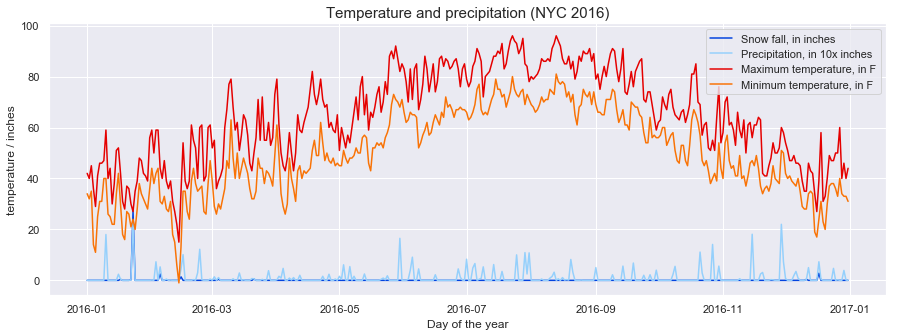

In [660]:
# plotting weather data 
colors = sns.xkcd_palette(["blue", "light blue", 'red', 'orange'])
sns.set(rc={'figure.figsize':(15,5)}, palette = sns.set_palette(colors, color_codes=False))

fig, ax = plt.subplots()

sns.lineplot(x=weather_df['date'], y=weather_df['snow fall'], label="Snow fall, in inches")
sns.lineplot(x=weather_df['date'], y=weather_df['precipitation']*10, label="Precipitation, in 10x inches")
sns.lineplot(x=weather_df['date'], y=weather_df['maximum temperature'], label="Maximum temperature, in F")
sns.lineplot(x=weather_df['date'], y=weather_df['minimum temperature'], label="Minimum temperature, in F")

ax.set_title("Temperature and precipitation (NYC 2016)", {'fontsize': 15})
ax.set_xlabel("Day of the year")
ax.set_ylabel("temperature / inches")

fig.show()

### Running data preprocessing 

Before feeding the data to train the model, we can extract a number of useful features that are likely correlated with travel time between two points. To do that, we first convert the DateTime strings into the proper DateTime format and then extract the following: 

- **hour of day** (likely correlated with traffic speed) 
- **day of the week** (likely correlated with traffic speed) 
- **day of the year** (useful for visualizations) 
- **day is weekend** (useful for visualizations) 
- **day is bank holiday** (likely correlated with traffic speed) 
- **month** (useful for visualization, potentially correlated with traffic speed during e.g., summer holidays) 
- **travel distance**, i.e., longitude-latitude difference (likely correlated with travel time) 
- **travel distance**, i.e, geometric distance in km (likely correlated with travel time) 
- **average speed in km/h** (useful for visualizations, cannot be used as explanatory feature) 
- **match weather data to taxi trips by day** (temperature, precipitation snowfall, etc., are likely all correlated with traffic speed and thus travel time)

In [4]:
# data preprocessing function
def load_preprocess(): 
    
    # time execution 
    start = time.process_time() 
    
    # load taxi data from memory
    taxi_df = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\nyc_taxi\\train.csv', sep=',')
    # load weather data from memory 
    weather_df = pd.read_csv('C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\nyc_taxi\\weather_data_nyc_2016.csv', 
                             sep=',')
    
    # convert datetime strings into proper datetime format: Y-m-d H-M-S
    print("Formatting datetime..")
    taxi_df["dropoff_datetime"] = pd.to_datetime(taxi_df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
    taxi_df["pickup_datetime"] = pd.to_datetime(taxi_df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')
    weather_df["date"] = pd.to_datetime(weather_df["date"], format='%d-%m-%Y')    
        
    # Extract variables from datetime
    print("Extracting variables from datetime..")
    taxi_df["pickup_hour"] = taxi_df["pickup_datetime"].dt.hour
    taxi_df["pickup_weekday"] = taxi_df["pickup_datetime"].dt.weekday 
    taxi_df["pickup_day"] = taxi_df["pickup_datetime"].dt.dayofyear
    taxi_df["pickup_month"] = taxi_df["pickup_datetime"].dt.month
    taxi_df["pickup_is_weekend"] = np.where(taxi_df['pickup_weekday']>4, 1, 0)
    taxi_df["pickup_is_holiday"] = np.where((taxi_df['pickup_day']==151) | (taxi_df['pickup_day']==1), 1, 0)
    weather_df['pickup_day'] = weather_df["date"].dt.dayofyear
    
    # format weather data
    print("Formatting weather data..")
    weather_df.replace('T', value=0.00, inplace=True)
    weather_df.replace(0.0, value=0.00, inplace=True)
    for column in ['precipitation', 'snow fall', 'snow depth']: 
        weather_df[column] = weather_df[column].astype("float")

    # add weather data to taxi data 
    print("Merging taxi and weather data..")
    df = pd.merge(taxi_df, weather_df[['pickup_day', 'minimum temperature', 'maximum temperature',
                                            'precipitation', 'snow fall', 'snow depth']], 
                       left_on='pickup_day', right_on='pickup_day')
    
    # Get latitude and longitude differences 
    print("Computing long/lat differences for each trip..")
    df["latitude_difference"] = df["dropoff_latitude"] - df["pickup_latitude"]
    df["longitude_difference"] = df["dropoff_longitude"] - df["pickup_longitude"]
    
    # Calculate trip distance in km 
    print("Computing trip distance ('as the crow flies') in km..")
    df['distance_km'] = df.apply(lambda x: geopy.distance.distance((x[6], x[5]), (x[8], x[7])).km, 
                                 axis = 1)
    
    # Calculate avg trip speed 
    df['avg_trip_speed_kmh'] = 60*60*df['distance_km']/df['trip_duration']
        
    print("Loading and preprocessing complete. Time for execution %i seconds" % (time.process_time()-start))
    
    return df

In [5]:
dataframe = load_preprocess()

Formatting datetime..
Extracting variables from datetime..
Formatting weather data..
Merging taxi and weather data..
Computing long/lat differences for each trip..
Computing trip distance ('as the crow flies') in km..
Loading and preprocessing complete. Time for execution 423 seconds


### Excluding invalid / erroneous data points

A closer look at the data reveals four categories of outliers or possibly faultily recorded data points: 
- longitude/latitude positions well outside the broader NYC area (as far outside as California or the Atlantic ocean) - see map below
- trip durations in excess of 12h or even 24h
- trip distances of less than 300m 
- average speeds >100 km/h (and even well within supersonic range)

It is very likely that some of these are data errors rather than e.g., taxis delivering lucky passengers at supersonic speeds, or dropping them into the Atlantic ocean. In the following section, we will thus exclude c. 30,000 data points (i.e., c. 2% of the total) 

#### Distribution of pickup and dropoff points in dataset

<img src='images/Taxi_global.PNG' width='600' height='600'/>

#### Distribution of trip durations, trips distances and average speeds 

We can plot the outliers of trip durations, distances traveled, and average speeds below. We find the following:

- Trip durations: recorded trips range from 0 to 1000 hours
- Trip distances: recorded distances range from 0 to >1200 km 
- Average speed: calculated average speeds range from 0 to >8000 km/h 

Text(0.5, 1.0, 'Distribution of average speeds, in km/h')

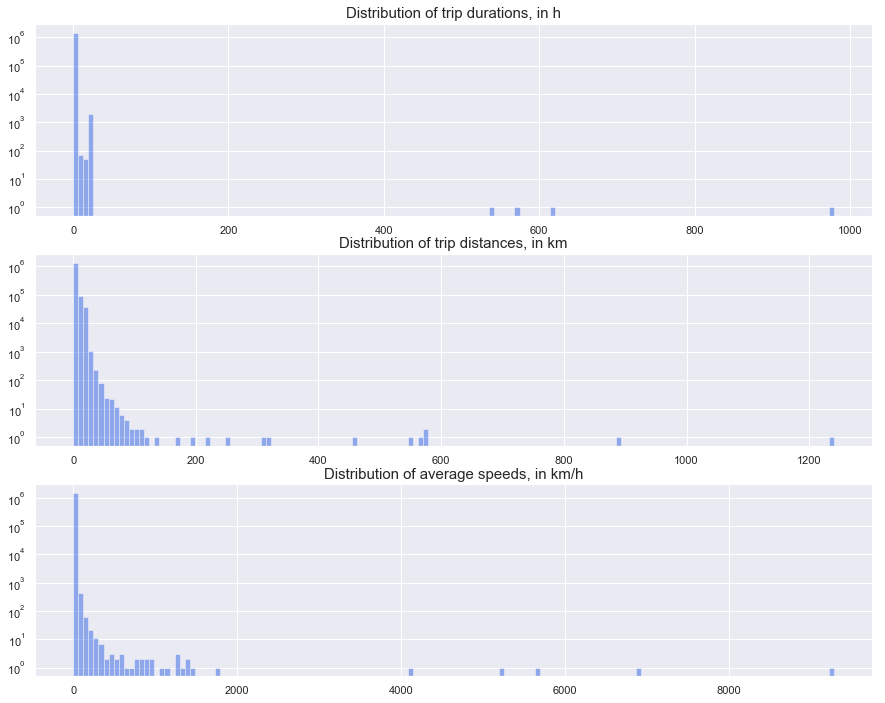

In [96]:
# plot trip durations, trip distance, average speed 
colors = sns.xkcd_palette(["blue"])
sns.set(rc={'figure.figsize':(15,12)}, palette = sns.set_palette(colors, color_codes=False))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
ax1.set_yscale('log'), ax2.set_yscale('log'), ax3.set_yscale('log')

sns.distplot(dataframe['trip_duration']/3600, bins=150, norm_hist = False, kde = False, ax=ax1)
sns.distplot(dataframe['distance_km'], bins=150, norm_hist = False, kde = False, ax=ax2)
sns.distplot(60*60*dataframe['distance_km']/dataframe['trip_duration'], bins=150, norm_hist = False, 
             kde = False, ax=ax3)

ax1.set_xlabel(""), ax2.set_xlabel(""), ax3.set_xlabel("")
ax1.set_title("Distribution of trip durations, in h", {'fontsize': 15})
ax2.set_title("Distribution of trip distances, in km", {'fontsize': 15})
ax3.set_title("Distribution of average speeds, in km/h", {'fontsize': 15})

#### Excluding outliers and invalid data points

The following function eliminates positional, distance, and trip duration outliers: 

In [6]:
def eliminate_invalid_data():
    # time execution 
    start = time.process_time() 
    
    df = dataframe
    # drop longitude outlier positions 
    print("Excluding positional outliers..")
    initial_count = df['id'].count()
    for longitude in ['pickup_longitude', 'dropoff_longitude']: 
        df.drop(df[df[longitude] < -74.4].index, inplace=True)
        df.drop(df[df[longitude] > -73.6].index, inplace=True)
    
    # drop latitude outlier positions 
    for longitude in ['pickup_latitude', 'dropoff_latitude']: 
        df.drop(df[df[longitude] < 40.5].index, inplace=True)
        df.drop(df[df[longitude] > 41.1].index, inplace=True)
        
    # delete speed outliers 
    df.drop(df[df['avg_trip_speed_kmh'] > 80].index, inplace=True)
    df.drop(df[df['avg_trip_speed_kmh'] < 3].index, inplace=True)
    df.drop(df[df['avg_trip_speed_kmh'].isna() == True].index, inplace=True)
    # delete near-zero distance trips 
    df.drop(df[df['distance_km'] < 0.3].index, inplace=True)
    # delete trips longer than 3h 
    df.drop(df[df['trip_duration'] > 10800].index, inplace=True)
    
    print("%i outliers excluded" % (initial_count-df['id'].count()))
    print("Loading and preprocessing complete. Time for execution %i seconds" % (time.process_time()-start))
    
    return df

In [7]:
dataframe = eliminate_invalid_data()

Excluding positional outliers..
33481 outliers excluded
Loading and preprocessing complete. Time for execution 6 seconds


The resulting new distributions are shown below:

Text(0.5, 1.0, 'Distribution of average speeds, in km/h')

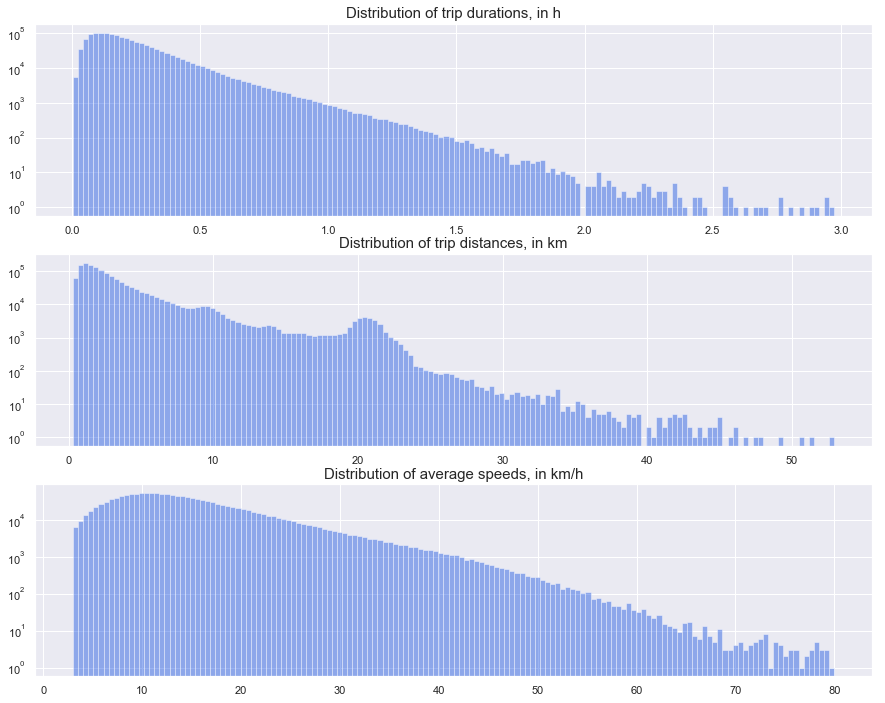

In [139]:
# plot trip durations, trip distance, average speed 
colors = sns.xkcd_palette(["blue"])
sns.set(rc={'figure.figsize':(15,12)}, palette = sns.set_palette(colors, color_codes=False))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
ax1.set_yscale('log'), ax2.set_yscale('log'), ax3.set_yscale('log')

sns.distplot(dataframe['trip_duration']/3600, bins=150, norm_hist = False, kde = False, ax=ax1)
sns.distplot(dataframe['distance_km'], bins=150, norm_hist = False, kde = False, ax=ax2)
sns.distplot(60*60*dataframe['distance_km']/dataframe['trip_duration'], bins=150, norm_hist = False, 
             kde = False, ax=ax3)

ax1.set_xlabel(""), ax2.set_xlabel(""), ax3.set_xlabel("")
ax1.set_title("Distribution of trip durations, in h", {'fontsize': 15})
ax2.set_title("Distribution of trip distances, in km", {'fontsize': 15})
ax3.set_title("Distribution of average speeds, in km/h", {'fontsize': 15})

### Taking a closer look at the data

Now that the data is somewhat cleaned, we can take a closer look at the patterns. 

As expected, plotting average speed against hour of day (first plot below), and against day of the week (second plot below) reveals an expected pattern with slower speeds during the work day and work week 

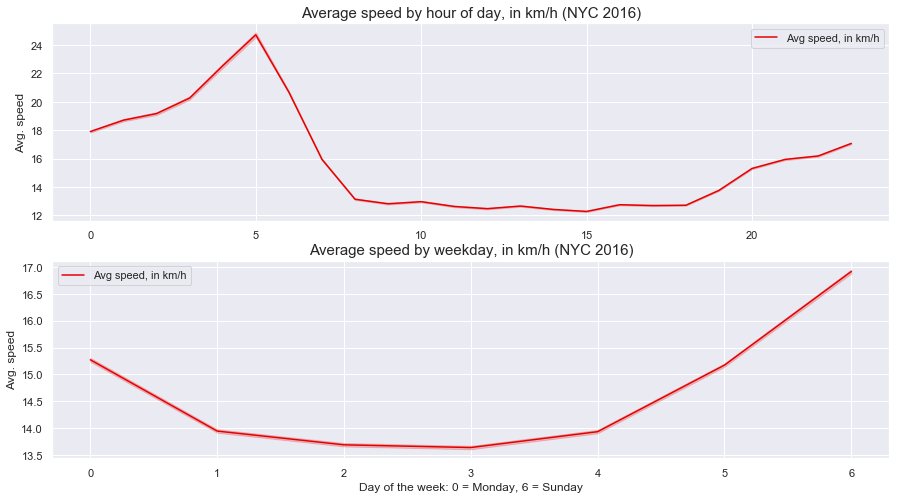

In [662]:
# plot avg speed by hour of day  
colors = sns.xkcd_palette(["red"])
sns.set(rc={'figure.figsize':(15,8)}, palette = sns.set_palette(colors, color_codes=False))
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

sns.lineplot(x=dataframe['pickup_hour'], y=60*60*dataframe['distance_km']/dataframe['trip_duration'], 
             label="Avg speed, in km/h", ax=ax1)
sns.lineplot(x=dataframe['pickup_weekday'], y=60*60*dataframe['distance_km']/dataframe['trip_duration'], 
             label="Avg speed, in km/h", ax=ax2)

ax1.set_title("Average speed by hour of day, in km/h (NYC 2016)", {'fontsize': 15})
ax1.set_xlabel(""), ax1.set_ylabel("Avg. speed")
ax2.set_title("Average speed by weekday, in km/h (NYC 2016)", {'fontsize': 15})
ax2.set_xlabel("Day of the week: 0 = Monday, 6 = Sunday"), ax2.set_ylabel("Avg. speed")

fig.show()

Looking at average speed over the course of half a year, we can see that the best predictor still remains the weekends and bank holidays. However, the 4th weekend of the year also shows a big impact of snow on average speed (while precipitation seems to have less of an impact overall)

(Text(0, 0.5, 'Avg speed'),
 Text(0, 0.5, 'Avg speed'),
 Text(0, 0.5, 'Avg speed'),
 Text(0, 0.5, 'Avg speed'))

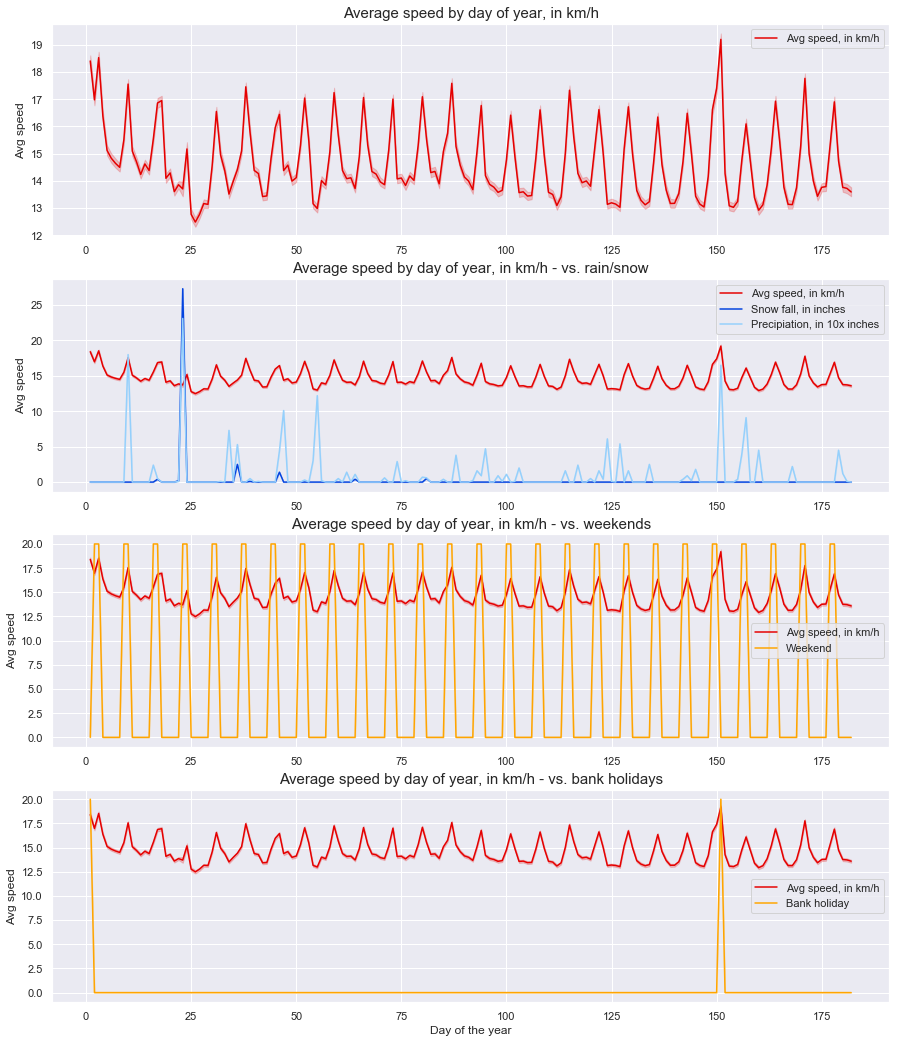

In [665]:
colors = sns.xkcd_palette(["red", "blue", "light blue", "grey"])
sns.set(rc={'figure.figsize':(15,18)}, palette = sns.set_palette(colors, color_codes=False))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)

# plot 1 
sns.lineplot(x=dataframe['pickup_day'], y=60*60*dataframe['distance_km']/dataframe['trip_duration'], 
             label="Avg speed, in km/h", ax=ax1)
# plot 2 
sns.lineplot(x=dataframe['pickup_day'], y=60*60*dataframe['distance_km']/dataframe['trip_duration'], 
             label="Avg speed, in km/h", ax=ax2)
sns.lineplot(x=dataframe['pickup_day'], y=dataframe['snow fall'], label="Snow fall, in inches", ax=ax2)
sns.lineplot(x=dataframe['pickup_day'], y=dataframe['precipitation']*10, label="Precipiation, in 10x inches", ax=ax2)
# plot 3 
sns.lineplot(x=dataframe['pickup_day'], y=60*60*dataframe['distance_km']/dataframe['trip_duration'], 
             label="Avg speed, in km/h", ax=ax3)
sns.lineplot(x=dataframe['pickup_day'], y=dataframe['pickup_is_weekend']*20, ax=ax3, label="Weekend", color="orange")
# plot 4 
sns.lineplot(x=dataframe['pickup_day'], y=60*60*dataframe['distance_km']/dataframe['trip_duration'], 
             label="Avg speed, in km/h", ax=ax4)
sns.lineplot(x=dataframe['pickup_day'], y=dataframe['pickup_is_holiday']*20, label="Bank holiday", ax=ax4, color="orange")



ax1.set_title("Average speed by day of year, in km/h", {'fontsize': 15})
ax1.set_xlabel(""), ax2.set_xlabel(""), ax3.set_xlabel(""), ax4.set_xlabel("Day of the year")
ax2.set_title("Average speed by day of year, in km/h - vs. rain/snow", {'fontsize': 15})
ax3.set_title("Average speed by day of year, in km/h - vs. weekends", {'fontsize': 15})
ax4.set_title("Average speed by day of year, in km/h - vs. bank holidays", {'fontsize': 15})
ax1.set_ylabel("Avg speed"), ax2.set_ylabel("Avg speed"), ax3.set_ylabel("Avg speed"), ax4.set_ylabel("Avg speed") 

### Correlation between dataset features and average speed <a class="tocSkip">

As expected, some of the features are highly correlated with each other (such as snowfall and precipitation). However, I still choose to include all of those features, as e.g., snow has a much bigger impact than precipitation (though also being rarer).

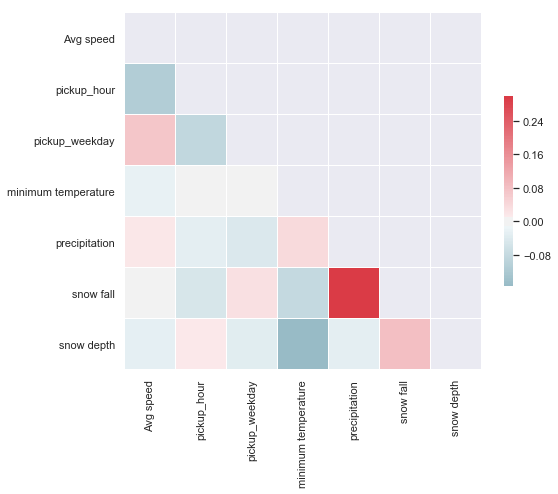

In [176]:
# Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
feat_cols = ['pickup_hour', 'pickup_weekday', 'minimum temperature', 'precipitation', 'snow fall', 'snow depth']
df = pd.DataFrame()
df["Avg speed"] = 60*60*dataframe['distance_km']/dataframe['trip_duration']
df[feat_cols] = dataframe[feat_cols]
    
corr = df.corr()
# Generate a mask to hide the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Splitting the data into training and evaluation sets

Since we have a relatively large dataset of 1.5m data points, we can afford to only **split off 5% as evaluation set** (which still amounts to c. 70,000 recorded trips). The below function randomly shuffles the dataset and then performs this split. It uses the recorded trip duration as label for the model to predict.  

In [14]:
# split data into train and evaluate set 
def split_data(feat_cols, split=0.95):
    np.random.seed(seed=1)
    # create randomized indeces 
    num_trips = dataframe.shape[0]
    train_split = int(num_trips * split)
    indeces = np.random.permutation(num_trips)
    train_indeces = indeces[:train_split]
    eval_indeces = indeces[train_split:]
    
    # split dataframe using randomized indeces and train split ratio 
    train_df = dataframe.iloc[train_indeces]
    eval_df = dataframe.iloc[eval_indeces]
    
    # extract features and labels from dataframes 
    train_features = pd.DataFrame() 
    train_labels = pd.DataFrame() 
    eval_features = pd.DataFrame() 
    eval_labels = pd.DataFrame()
    train_features[feat_cols] =  train_df[feat_cols]
    train_labels['trip_duration'] = train_df['trip_duration']
    eval_features[feat_cols] = eval_df[feat_cols]
    eval_labels['trip_duration'] = eval_df['trip_duration']
    
    return (train_features, train_labels, eval_features, eval_labels)

In [15]:
feat_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
             'pickup_hour', 'pickup_weekday', 
             'latitude_difference', 'longitude_difference', 'distance_km', 
             'minimum temperature', 'snow depth', 'pickup_is_holiday', 'precipitation']

train_features, train_labels, eval_features, eval_labels = split_data(feat_cols = feat_cols)

# check shapes
print(train_features.shape, eval_features.shape, train_labels.shape, eval_labels.shape)

(1353904, 13) (71259, 13) (1353904, 1) (71259, 1)


### Setting up the model 

The model is an out-of-the-box gradient boosted decision tree (using XGBoost). Most hyperparameters are left at their default values, except for "max_depth" (i.e., maximum depth of individual decision trees), which is increased to 17. 

#### Choice of loss function 

For this task, I chose to use the Mean Absolute Error, MAE (instead of e.g., Root Mean Squared Error, RMSE) as error metric to minimize. While RMSE is continuously differentiable, it places a greater weight on large outlier values (since individual errors are squared before being averaged and the square root is applied). However, in our current case, it would be good for the model to mostly ignore outlier values and rather improve on the bulk of the data. MAE also has the advantage of being readily interpretable (i.e., as the average mistake the model makes in predicting trip times). 

#### Baseline model 

To put the model performance into context, we use the training set to calculate overall average speed. This can then be used to predict travel times in the evaluation set by multiplying average training set speed by the distances in the evaluation set for each data point. Doing so results in a baseline Mean Average Error of c. 347 seconds (i.e., the predicted travel time is on average 347 seconds off). This seems already to be a reasonable guess that the model should hopefully beat by a significant margin.

#### Calculate baseline MAE

In [21]:
# baseline model: average total distance over total travel time and use the time/km as baseline estimator 
avg_speed = np.average(train_features["distance_km"] / train_labels['trip_duration'])  # speed in km/s 

baseline_predictions = np.array(eval_features["distance_km"] / avg_speed)

baseline_mae = np.average(abs(baseline_predictions - np.array(eval_labels['trip_duration'])))
print("The baseline Mean Average Error is "+str(baseline_mae)+" seconds")

The baseline Mean Average Error is 346.6562996409347 seconds


#### Choosing parameters 

In [643]:
parameters = {
    'learning_rate':      0.1,
    'max_depth':          17,  
    'min_child_weight':   1, 
    'gamma':              0.1,
    'subsample':          1,
    'colsample_bytree':   1,
    'colsample_bylevel':  1,
    'reg_alpha':          0,
    'reg_lambda':         1,
    'n_estimators':       100,
    'silent':             True, 
    'n_jobs':             -1
}

### Running training

In [644]:
# set up training 
XGB_model = XGBRegressor(**parameters)

# define evaluation set used during training  
eval_set = [(train_features, train_labels), (eval_features, eval_labels)]

# run training. For eval_metric, we can specifiy multiple measures that we are interested in  
XGB_model.fit(train_features, train_labels, eval_metric=['mae'], 
          eval_set=eval_set, early_stopping_rounds=3, verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Evaluating the model

The final evaluation set MAE for the model comes to 160 seconds (i.e., the model is on average 2:40 minutes, or 160 seconds, wrong). In comparison, our baseline estimate was 347 seconds (or c. 5:45 minutes) wrong on average, so we see indeed a significant improvement. 

Plotting the MAE for the evaluation and training set, we see that the model slightly overfits to the training set (achieving a MAE of c. 1:20 minutes, or 80 seconds).

In [645]:
training_results = XGB_model.evals_result()
final_eval_MAE = training_results['validation_1']['mae'][-1]
print("Final evaluation MAE: "+str(final_eval_MAE))

Final evaluation MAE: 159.558823


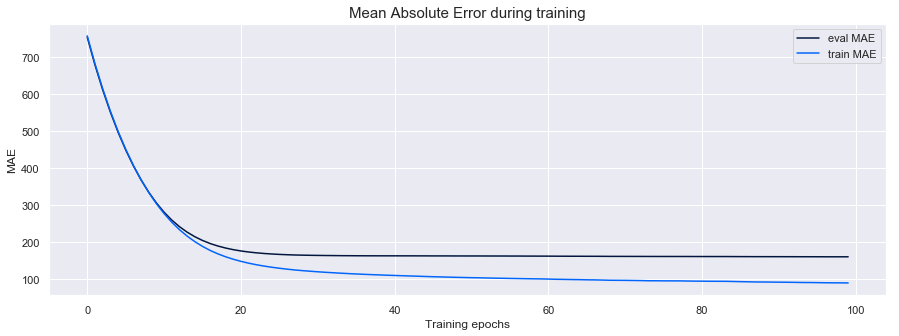

In [646]:
# retrieve performance metrics
epochs = np.arange(len(training_results['validation_0']['mae']))

# plot metrics 
colors = sns.xkcd_palette(["navy", "bright blue"])
sns.set(rc={'figure.figsize':(15,5)}, palette = sns.set_palette(colors, color_codes=False))

fig, ax = plt.subplots()

sns.lineplot(x=epochs, y=training_results['validation_1']['mae'], label="eval MAE")
sns.lineplot(x=epochs, y=training_results['validation_0']['mae'], label="train MAE")

ax.set_title("Mean Absolute Error during training", {'fontsize': 15})
ax.set_xlabel("Training epochs"), ax.set_ylabel("MAE")

fig.show()

### Taking a look at the model errors

Plotting the model errors (predictions - actual travel times), we would hope to find a balanced and random distribution of (ideally small) errors around a zero mean. Looking at the below plot we see a somewhat skewed distribution that suggests some cases where actual travel time is significantly larger than predicted travel time (with one example being almost 8000 seconds, or almost 2.5h, larger than the predictions). These error outliers could be due to outliers still in the dataset where e.g., a taxi was waiting for a passenger with the taximeter running. More carefully eliminating additional outliers would probably increase the precision of the model quite drastically, however, I want to refrain from over-engineering the data. 

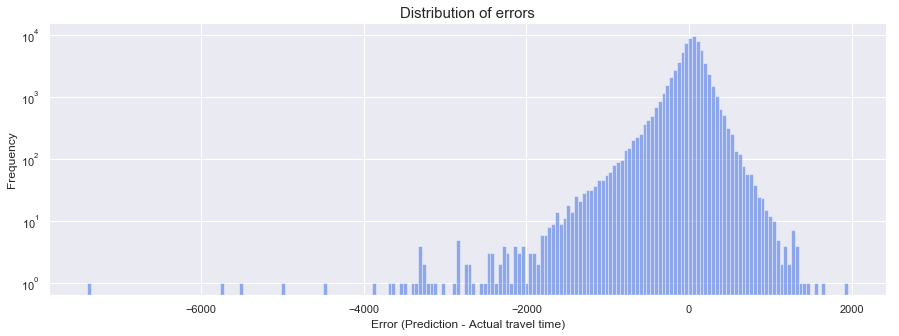

In [653]:
# retrieve performance metrics
predictions = XGB_model.predict(eval_features)

# plot metrics 
colors = sns.xkcd_palette(["blue", "pale orange"])
sns.set(rc={'figure.figsize':(15,5)}, palette = sns.set_palette(colors, color_codes=False))

fig, ax = plt.subplots()
ax.set_yscale('log')
sns.distplot(predictions-np.array(eval_labels['trip_duration']), label="Error", bins=200, norm_hist = False, kde = False)

ax.set_title("Distribution of errors", {'fontsize': 15})
ax.set_xlabel("Error (Prediction - Actual travel time)"), ax.set_ylabel("Frequency")

fig.show()

### Taking a look at feature importance

XGBoost also allows us to have a closer look at the relative importance of the different input features.  

Interestingly, longitude seems to be by far the best most important predictor for travel time. This could be because the East River and Hudson River run roughly North to South and crossing them (East - West) can drastically increase travel time for relatively short direct line distances. 

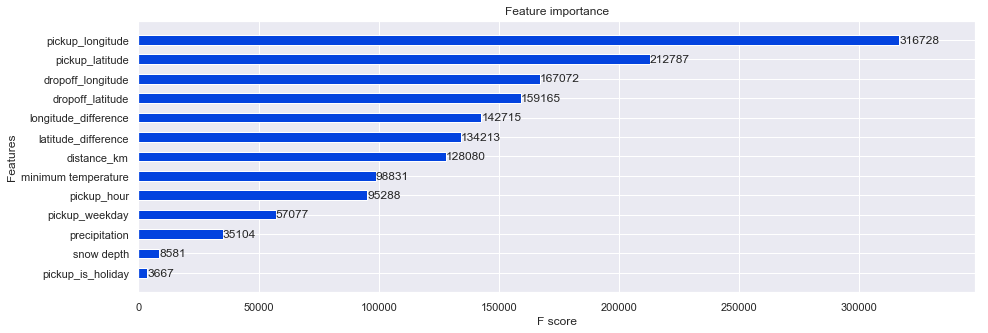

In [38]:
# plot feature importance
plot_importance(XGB_model, height = 0.5)
plt.show()

### Converting results to map view 

We can visualize a specific route and use the model to calculate the expected travel time. In this case, we are assuming a ride from **JFK's terminal 4 to the Empire State Building** at 12pm on a Monday. The coordinates were taken from google maps and are listed below in the format (longitude, latitude). The numbers in red represent estimated cumulative travel time.

In [108]:
# longitude, latitude coordinates 
JFK_airport = (-73.782401, 40.644471) 
Empire_State_Building = (-73.9857, 40.7484)

<img src='images/JFK_Empire1.JPG' width='600' height='500'/>

The above plot incorporates the following function that uses our model to predict travel time between any two points in/around NYC

In [276]:
def predict_travel_time(pickup, dropoff, datetime=(0,12), temperature = 50, precipitation = 0, snow_depth = 0, holiday=0):
    """
    pickup, dropoff format -- (long, lat)
    datetime format -- (weekday, hour)
    temperature -- in Fahrenheit 
    holiday -- binary (0 OR 1)
    returns travel time, in minutes
    """
    pickup_longitude, pickup_latitude = pickup
    dropoff_longitude, dropoff_latitude = dropoff
    pickup_weekday, pickup_hour = datetime 
    df = pd.DataFrame({
        'pickup_longitude' : pickup_longitude,
        'pickup_latitude' : pickup_latitude, 
        'dropoff_longitude' : dropoff_longitude, 
        'dropoff_latitude' : dropoff_latitude, 
        'pickup_hour' : pickup_hour, 
        'pickup_weekday' : pickup_weekday, 
        'latitude_difference' : pickup_latitude-dropoff_latitude, 
        'longitude_difference' : pickup_longitude-dropoff_longitude, 
        'distance_km' : geopy.distance.distance((pickup_latitude, pickup_longitude), (dropoff_latitude, dropoff_longitude)).km, 
        'minimum temperature' :  temperature, 
        'snow depth' : snow_depth, 
        'pickup_is_holiday' : holiday,
        'precipitation' : [precipitation]
        })
    
    prediction = XGB_model.predict(df)
    prediction = round(prediction.item()/60, 2) 
    
    return prediction 


Using the coordinates for **JFK's terminal 4 arrivals** and the **Empire State Building**, we get c. **58.5 minutes** as likely travel time (assuming it is Monday, 12pm with no precipitation, or snow on the street). This seems reasonable (even though the traffic is mostly anything but reasonable between these two points. However, solving NYC's traffic problems is beyond the scope of this notebook).  

In [121]:
prediction = predict_travel_time(pickup=JFK_airport, dropoff=Empire_State_Building, datetime=(0, 12), 
                           temperature = 50, precipitation = 0, snow_depth = 0, holiday=0)
print('The estimated travel time is '+str(prediction)+' minutes')

The estimated travel time is 58.48 minutes


## Building an evolutionary route optimizer 

*"evolution is a tinkerer, not an engineer"*, Francois Jacob*

In a nutshell, the route optimization algorithm uses **evolution through computational selection.** This means creating a number of possible (and initially random) route sequences and selecting those that are fastest as "parents" for the next generation. The next generation of route sequences is created by (randomly) combining subsequences from two parents. This allows to again select the "fittest" (i.e., fastest) route sequences from the new generation to become parents to the following generation. This process of **random combination** and **non-random selection** continues until a good solution (i.e., fast route) emerges. Crucially, this is not necessarily the best possible solution, but hopefully, one that is reasonably close to that. It is also reached with much less computational time.    

In our case, the algorithm needs three types of helper functions: 

1. create a number of random guesses of possible trip sequences to visit all places in a list and return to the point of origin
2. evaluate each random guess by summing up the predicting total travel times of each individual route segment. Select the best guesses to become "parents" for the next generation  
3. recombine random route subsegments from "parents" to form "children" that make up the next generation 

*Francois Jacob, "Evolution and Tinkering," published in Science in 1977

The inspiration and some of the code for the genetic algorithm was borrowed and modified from https://github.com/ZWMiller/PythonProjects/blob/master/genetic_algorithms/evolutionary_algorithm_traveling_salesman.ipynb

### Creating random guesses  

Combined, the following two functions create a specified number of random route sequences which always start and end at the same location. More specifically, they receive a list of locations to visit as input and return random sequences of those locations as output (making sure that the first location from the list of input locations is also the last location)

In [350]:
# create one random guess for a location sequence
def random_guess(locations):
    """
    Creates a possible path between all points, returning to the point of origin
    locations -- dictionary of locations and corresponding coordinates 
    """
    start = list(locations.keys())[0]
    guess = list(locations.keys())[1:]
    np.random.shuffle(guess)
    route = [start, (*guess), start] 
    return list(route)

# create multiple random guesses 
def create_generation(locations, num=10): 
    generation = [random_guess(locations) for location in range(num)]
    return generation

In [535]:
# test functions 
locations = {
    'JFK_airport' : (-73.782401, 40.644471), 
    'Empire_State_Building' : (-73.9857, 40.7484),
    'Carnegie_hall' : (-73.979929, 40.765888),
    'Battery_park' : (-74.014478, 40.703216),
    'Brighton_Beach' : (-73.969623, 40.574749),
    'Brooklyn_Botanic_Garden' : (-73.962377, 40.669493),
    }
test_generation = create_generation(locations, num=2)

We can see the two randomly generated test routes below, with total travel times of 244 minutes and 235 minutes respectively

<table><tr><td><img src='images/route0.JPG'></td><td><img src='images/route1.JPG'></td></tr></table>

### Evaluating routes

The following two functions help to evaluate travel times for every single route in a generation of routes

In [536]:
def evaluate_single_guess(guess): 
    """
    Evaluates travel time for single travel sequence
    guess -- list of destinations in the order of travel. Need to be present in a locations dictionary that links them to 
    long/lat coordinates 
    """
    # join locations with their respective coordinates 
    locations = dict(zip(guess, [locations_dictionary[place] for place in guess]))
    
    # for each successive pair of locations en route, estimate travel time and save in list 
    travel_time = [0]
    for i in range(len(locations)-1):
        travel_time.append(predict_travel_time(list(locations.values())[i], list(locations.values())[i+1]))
    
    # add travel time for last leg back (since last location is same as first, it drops from zip() function)
    travel_time.append(predict_travel_time(locations_dictionary[guess[-2]], locations_dictionary[guess[-1]]))
    
    total_travel_time = round(np.sum(travel_time), 2)
    return total_travel_time

def check_fitness(guesses): 
    """
    Evaluates travel time for a list of travel sequences  
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, evaluate_single_guess(guess)))
    return fitness_indicator

In [537]:
# test functions 
test_fitness = check_fitness(test_generation)
print(test_fitness)

[(['JFK_airport', 'Battery_park', 'Empire_State_Building', 'Brighton_Beach', 'Brooklyn_Botanic_Garden', 'Carnegie_hall', 'JFK_airport'], 235.62), (['JFK_airport', 'Brooklyn_Botanic_Garden', 'Carnegie_hall', 'Empire_State_Building', 'Battery_park', 'Brighton_Beach', 'JFK_airport'], 170.91)]


### Recombining best guesses 

The following three functions select "parents" from the current generation and recombine them to "children" in the next generation. Collectively, they do the following:  

1. Select fastest route sequences from the current generation. These become "parents" for the next generation (plus some random routes to add diversity) 
2. From "parent 1", randomly select locations and **their position within the route sequence**
3. Transfer selected locations (and their position in the sequence) to "child" 
4. Fill the remaining not yet filled positions in the "child" sequence with the corresponding locations from "parent 2". Move from left to right and make sure not to duplicate positions: 

In [592]:
def select_parents_from_generation(current_generation, take_best_N=10, take_random_N=5, verbose=True):
    """
    Selects parents for the next generation (by choosing fastest route sequences in current generation)
    """
    # Select best guesses from current generation 
    fitness_scores = check_fitness(current_generation)
    sorted_guesses = sorted(fitness_scores, key=lambda x: x[1]) # sorts so lowest is first, which we want
    parents = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = parents[0]
    
    if verbose:
        # Show the best current guess
        print(best_guess)
    
    # Add some random guesses to the list of parents for diversity
    for _ in range(take_random_N):
        index = np.random.randint(len(current_generation))
        parents.append(current_generation[index])
    
    np.random.shuffle(parents)
    return parents, best_guess


def make_child(parent1, parent2):
    """ 
    Create one child by combining route sequences from two parent routes
    """
    # take random selection of locations from parent 1 
    parent1_index = np.arange(0, len(parent1), 1)
    parent1_index_subset = list(np.random.choice(parent1_index, replace=False, size=len(parent1)//2))
    
    # create empty list for child 
    child = [-1 for _ in parent1]
    # make sure start- and end points are preserved 
    child[0] = parent1[0]
    child[-1] = parent1[-1]
    
    # place selected locations from parent 1 into child (at their respective positions in the parent 1 sequence)
    for ix in range(0, len(child)):
        if ix in parent1_index_subset: 
            child[ix] = parent1[ix]

    # fill the remaining locations in child with the respective values from parent 2 
    for ix, gene in enumerate(child):
        if gene == -1:
            for gene2 in parent2:
                if gene2 not in child:
                    child[ix] = gene2
                    break
    
    # make sure the last value is the first value 
    child[-1] = child[0]
    return child


def make_children(parents, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair. 
    Pairing happens by pairing the first and last entries. Then the second and second from last, and so on.
    """
    mid_point = len(parents)//2
    next_generation = [] 
    
    for ix, parent in enumerate(parents[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, parents[-ix-1]))
    return next_generation

In [588]:
# test functions 
test_parents = create_generation(locations, num=2)
print(test_parents)
next_test_generation = make_children(parents=test_parents)
print(next_test_generation)

[['JFK_airport', 'Brooklyn_Botanic_Garden', 'Battery_park', 'Brighton_Beach', 'Carnegie_hall', 'Empire_State_Building', 'JFK_airport'], ['JFK_airport', 'Carnegie_hall', 'Brighton_Beach', 'Empire_State_Building', 'Battery_park', 'Brooklyn_Botanic_Garden', 'JFK_airport']]
[['JFK_airport', 'Carnegie_hall', 'Battery_park', 'Brighton_Beach', 'Empire_State_Building', 'Brooklyn_Botanic_Garden', 'JFK_airport']]


### Putting it all together 

The following function combines all of the above to generate an evolved solution for minimum travel time based on a number of user-specified locations

In [637]:
def evolve_routing(locations_to_visit, starting_gen_size, max_generations, take_best_N, take_random_N, 
                    children_per_couple, print_every_n_generations, verbose=False):
    """
    Takes in a dictionary of locations to visit (where the first locations is considered start- and end point) and iteratively 
    evolves trip sequences in order to minimize total travel time
    
    Arguments:
        locations_to_visit -- dictionary of locations; "location" : (longitude, latitude)
        starting_gen_size -- size of initial randomly generated route sequences 
        max_generations -- number of generations to iterate through 
        take_best_N -- number of fastest routes to pick as parents for the new generation 
        take_random_N -- number of random routes to pick as parents for the new generation 
        children_per_couple -- number of child combinations to create from a parent couple 
        print_every_n_generations -- how often to print in verbose mode 

    Returns:
    fitness_tracking -- list of travel times for best route at each generation 
    best_guess -- the fastest route at the end of the evolution
    """
    # create initial generation 
    current_generation = create_generation(locations_to_visit, num=starting_gen_size) 
    
    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations and i > 0:
            print("Generation %i: "%i, end='')
            print(str(len(current_generation))+" children")
            print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        
        # get parents for next generation 
        parents, best_guess = select_parents_from_generation(current_generation, 
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose)
        # save best guess so far 
        fitness_tracking.append(evaluate_single_guess(best_guess))
        
        # create new generation 
        current_generation = make_children(parents, children_per_couple=children_per_couple)
    
    return fitness_tracking, best_guess


## Running route optimization on 30 locations in the NYC/NJ area 

We will run the optimization on the following locations, each with (longitude, latitude) given:

In [ ]:
locations = {
    'JFK_airport' : (-73.782401, 40.644471), 'Carnegie_hall' : (-73.979929, 40.765888), 'Battery_park' : (-74.014478, 40.703216),
    'Brooklyn_bridge_park' : (-73.994499, 40.702979), 'High_line' : (-74.004616, 40.748948), 
    'Grand_Central' : (-73.977128, 40.753372), 'Time_Square' : (-73.986773, 40.755539), 
    'Natural_History_Museum' : (-73.973901, 40.782610), 'Liberty_State_Park' : (-74.054565, 40.703802),
    'Socrate_Sculpture_Park' : (-73.936562, 40.768436), 'Brighton_Beach' : (-73.969623, 40.574749),
    'Brooklyn_Botanic_Garden' : (-73.962377, 40.669493), 'Hamilton_Park' : (-74.015852, 40.770573),
    'Rockefeller_Center' : (-73.978559, 40.760209), 'UN_HQ' : (-73.968703, 40.749238), 
    'Empire_State_Building' : (-73.9857, 40.7484), 'Washington_Sqr_Park' : (-73.997370, 40.733145), 
    'Pier_15' : (-74.004132, 40.705448), 'World_Trade_Center' : (-74.013361, 40.712847), 
    'Rockefeller_Park' : (-74.016391, 40.716292), 'East_Village' : (-73.982950, 40.726977), 
    'Metropolitan_Museum' : (-73.962400, 40.778936), 'Bronx_Zoo' : (-73.882056, 40.852310),
    'North_Williamsburg' : (-73.963213, 40.720361), 'WNYC_Park' : (-73.959424, 40.730406), 
    'Queensbridge_Park' : (-73.947633, 40.756195), 'Brookly_Borough_Hall' : (-73.990826, 40.692599), 
    'Highland_Park' : (-73.881997, 40.685478), 'Fort_Totten' : (-73.782062, 40.789769), 
    'Queens_College' : (-73.819235, 40.736991)}

### Visualizing the trip locations 

The algorithm will the tasked to find the shortest route connecting all of the 30 locations shown below. The start and end point will be JFK airport: 

<table><tr><td><img src='images/NYC_full.JPG' width='390' height='390'></td><td><img src='images/Manhattan.JPG' width='435' height='435'></td></tr></table>


### Running the optimization algorithm 

The following window executes the route optimization algorithm on the 30 locations we defined. These are the relevant hyperparameters: 
- Number of randomly generated initial routes: 500 
- Number of generations to go through: 200 
- Number of fastest routes to select as "parents" from each generation: 150 
- Number of random routes to select as "parents" from each generation: 70 
- Number of "children" per "couple": 3  

In [638]:
fitness_tracking, best_guess = evolve_routing(locations_to_visit = locations, 
                                               starting_gen_size = 500, 
                                               max_generations = 200, 
                                               take_best_N = 150, 
                                               take_random_N = 70, 
                                               children_per_couple = 3, 
                                               print_every_n_generations = 5, 
                                               verbose=False)

### Visualizing the evolution of shortest travel times

We can see below that the solution seems to have stabilized after c. 80 generations. For a longer list of locations to visit, this would likely take more generations.

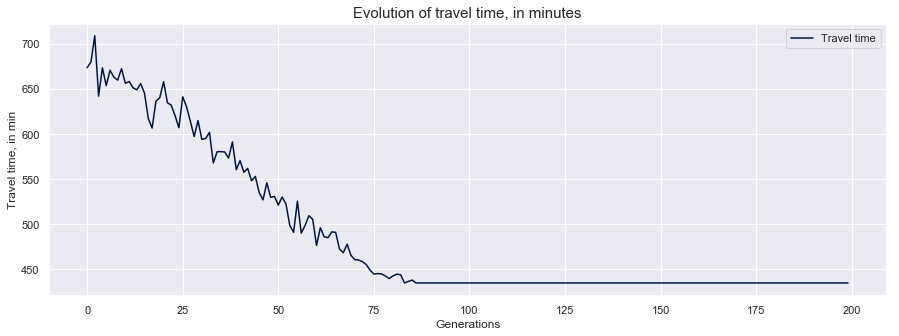

In [628]:
epochs = np.arange(len(fitness_tracking))

# plot metrics 
colors = sns.xkcd_palette(["navy", "bright blue"])
sns.set(rc={'figure.figsize':(15,5)}, palette = sns.set_palette(colors, color_codes=False))

fig, ax = plt.subplots()

sns.lineplot(x=epochs, y=fitness_tracking, label="Travel time")

ax.set_title("Evolution of travel time, in minutes", {'fontsize': 15})
ax.set_xlabel("Generations"), ax.set_ylabel("Travel time, in min")

fig.show()

### Comparing the best solutions after 5, 50, 75, and 200 generations 

Comparing the fastest routes of generations #5 and #50, two key differences become apparent: Firstly, instead of starting the journey north towards Queens, generation #50 travels south to Brighton Beach first, before probably taking advantage of highway 278 to relatively quickly arrive north in the Bronx. Secondly, the southward movement through Manhattan and New Jersey has become slightly less erratic. This adds up to an overall travel time advantage of 47 minutes. It took my local machine (Intel Core i5-7300U CPU) c. 5 minutes to arrive at the Generation #50 solution.

<table><tr><td><img src='images/5Gen.JPG'></td><td><img src='images/50Gen.JPG'></td></tr></table>

Generation #75 has evolved into a more circular shape where the route moves roughly clock-wise (and from south to north through Manhattan). This results in an improved travel time of almost 2 hours (i.e., 112 minutes) relative to generation #50. There is little improvement following generation #75 and another 125 generations only result in an additional 10 minutes of time savings. 

Overall, generation #200 has improved on generation #5 by c. 3.5 hours (i.e., 209 minutes) in travel time. 

<table><tr><td><img src='images/75gen.JPG'></td><td><img src='images/200Gen.JPG'></td></tr></table>

This is the final solution: 

JFK_airport > Queens_College > Highland_Park > Brighton_Beach > Brooklyn_Botanic_Garden > Brooklyn_Borough_Hall > Brooklyn_bridge_park > Pier_15 > Battery_park > Liberty_State_Park > Rockefeller_Park > World_Trade_Center > WNYC_Park > North_Williamsburg > East_Village > Washington_Sqr_Park > Hamilton_Park > High_line > Time_Square > Empire_State_Building > UN_HQ > Grand_Central > Rockefeller_Center > Carnegie_hall > Natural_History_Museum > Metropolitan_Museum > Queensbridge_Park > Socrate_Sculpture_Park > Bronx_Zoo > Fort_Totten > JFK_airport

### The public holiday solution <a class="tocSkip">

The above solution relies on a number of assumptions determining the point-to-point travel times not explicitly named so far:
- Day of the week: Monday
- Time of day: 12pm 
- No rain or snow at 50° Fahrenheit 

If we run the same model for a public holiday (e.g., Memorial Day) and assume the trip starts at 5am on a warm summer day, the following solution emerges:  

<img src='images/Gen100_holiday.JPG' width='500' height='500'/>

Interestingly, this time it pays off to move north first to visit Fort Totten before driving through Brooklyn and towards the southern tip of Manhattan. The highway 278 connection to get from the Bronx Zoo to Brighton Beach (which we saw at generation #50, but later discarded, in the non-holiday optimization) seems to be a much better option again. Not surprisingly, the total travel time is now down to 305 minutes. 

Here is the holiday route sequence: 

JFK_airport > Fort_Totten > Queens_College > Highland_Park > Brooklyn_Botanic_Garden > Brooklyn_Borough_Hall > Brooklyn_bridge_park > Pier_15 > Liberty_State_Park > Battery_park > World_Trade_Center > Rockefeller_Park > Washington_Sqr_Park > East_Village > North_Williamsburg > WNYC_Park > UN_HQ > Hamilton_Park> High_line > Empire_State_Building > Grand_Central > Time_Square > Carnegie_hall > Rockefeller_Center > Metropolitan_Museum > Natural_History_Museum > Queensbridge_Park > Socrate_Sculpture_Park > Bronx_Zoo > Brighton_Beach > JFK_airport

## Potential improvements and next steps for a real-world application 

There are three potential improvements to this model: 

1. **Increase the scope:** rather than just focusing on the NYC area, the scope could be extended to include entire states or the entire country. Using the google maps API would allow for this without much effort (see next point) 
2. **Improve point-to-point estimates and add actual routing:** the model currently relies on a statistical approach to calculating the point-to-point travel times. Using a ready solution such as the google maps API would not only increase the travel time estimate accuracy, it would **also provide an actual route for a car or truck to follow.** While this would probably not have a great impact on the fastest sequence of travel, it would allow to follow the proposed sequence on the road 
3. **Speed up the genetic algorithm:** The current algorithm runs reasonable fast for a 30 point sequence (i.e., around 5-10 minutes for convergence), however, there is plenty of scope to replace the "for" statements in the code with e.g., numpy array operations (for programmers with more time and skill). 

## Appendix
### Map plotting helper

Since the maps were created using tableau, I needed a helper function to save the list of locations along with some other useful information as a csv file. The following functions achieves this.

In [498]:
def prep_map(locations): 
    """
    points - list of travel locations  
    """
    # get long, lat location from dictionary 
    coordinates = [locations_dictionary[place] for place in locations]
    longs, lats = zip(*coordinates)
    paths = []
    travel_times = [0]

    for i in range(len(longs)): 
        paths.append(str(i+1)+"_"+str(i+2))
    for i in range(len(locations)-1):
        travel_times.append(predict_travel_time(locations_dictionary[locations[i]], locations_dictionary[locations[i+1]]))
    
    print(locations)
    
    route_df = pd.DataFrame({
    'longitude' : longs, 
    'latitude' : lats, 
    'order' : np.arange(1, len(longs)+1, 1),
    'path' : paths, 
    'location_name' : locations,
    'travel_times' : travel_times,
    'cum_travel_times' : list(np.cumsum(np.array(travel_times)))
    })
    
    # save to disk 
    route_df.to_csv(path_or_buf='C:\\Users\\Philipp Sorgenfrei\\Desktop\\path.csv', index=False)
    
    return route_df

In [632]:
route = prep_map(['JFK_airport', 'Queens_College', 'Highland_Park', 'Brighton_Beach', 'Brooklyn_Botanic_Garden', 'Brookly_Borough_Hall', 'Brooklyn_bridge_park', 'Pier_15', 'World_Trade_Center', 'Battery_park', 'Rockefeller_Park', 'Liberty_State_Park', 'North_Williamsburg', 'WNYC_Park', 'East_Village', 'Washington_Sqr_Park', 'Hamilton_Park', 'High_line', 'Empire_State_Building', 'Time_Square', 'UN_HQ', 'Grand_Central', 'Rockefeller_Center', 'Carnegie_hall', 'Natural_History_Museum', 'Metropolitan_Museum', 'Queensbridge_Park', 'Socrate_Sculpture_Park', 'Bronx_Zoo', 'Fort_Totten', 'JFK_airport'])

['JFK_airport', 'Queens_College', 'Highland_Park', 'Brighton_Beach', 'Brooklyn_Botanic_Garden', 'Brookly_Borough_Hall', 'Brooklyn_bridge_park', 'Pier_15', 'World_Trade_Center', 'Battery_park', 'Rockefeller_Park', 'Liberty_State_Park', 'North_Williamsburg', 'WNYC_Park', 'East_Village', 'Washington_Sqr_Park', 'Hamilton_Park', 'High_line', 'Empire_State_Building', 'Time_Square', 'UN_HQ', 'Grand_Central', 'Rockefeller_Center', 'Carnegie_hall', 'Natural_History_Museum', 'Metropolitan_Museum', 'Queensbridge_Park', 'Socrate_Sculpture_Park', 'Bronx_Zoo', 'Fort_Totten', 'JFK_airport']


In [640]:
route = prep_map(best_guess)

['JFK_airport', 'Fort_Totten', 'Queens_College', 'Highland_Park', 'Brooklyn_Botanic_Garden', 'Brookly_Borough_Hall', 'Brooklyn_bridge_park', 'Pier_15', 'Liberty_State_Park', 'Battery_park', 'World_Trade_Center', 'Rockefeller_Park', 'Washington_Sqr_Park', 'East_Village', 'North_Williamsburg', 'WNYC_Park', 'UN_HQ', 'Hamilton_Park', 'High_line', 'Empire_State_Building', 'Grand_Central', 'Time_Square', 'Carnegie_hall', 'Rockefeller_Center', 'Metropolitan_Museum', 'Natural_History_Museum', 'Queensbridge_Park', 'Socrate_Sculpture_Park', 'Bronx_Zoo', 'Brighton_Beach', 'JFK_airport']


In [619]:
locations_dictionary = {
    'JFK_airport' : (-73.782401, 40.644471), 
    'Carnegie_hall' : (-73.979929, 40.765888),
    'Battery_park' : (-74.014478, 40.703216),
    'Brooklyn_bridge_park' : (-73.994499, 40.702979),
    'High_line' : (-74.004616, 40.748948),
    'Grand_Central' : (-73.977128, 40.753372),
    'Time_Square' : (-73.986773, 40.755539),
    'Natural_History_Museum' : (-73.973901, 40.782610),
    'Liberty_State_Park' : (-74.054565, 40.703802),
    'Socrate_Sculpture_Park' : (-73.936562, 40.768436),
    'Brighton_Beach' : (-73.969623, 40.574749),
    'Brooklyn_Botanic_Garden' : (-73.962377, 40.669493),
    'Hamilton_Park' : (-74.015852, 40.770573),
    'Rockefeller_Center' : (-73.978559, 40.760209),
    'UN_HQ' : (-73.968703, 40.749238), 
    'Empire_State_Building' : (-73.9857, 40.7484), 
    'Washington_Sqr_Park' : (-73.997370, 40.733145),
    'Pier_15' : (-74.004132, 40.705448),
    'World_Trade_Center' : (-74.013361, 40.712847), 
    'Rockefeller_Park' : (-74.016391, 40.716292), 
    'East_Village' : (-73.982950, 40.726977), 
    'Metropolitan_Museum' : (-73.962400, 40.778936),
    'Bronx_Zoo' : (-73.882056, 40.852310),
    'North_Williamsburg' : (-73.963213, 40.720361), 
    'WNYC_Park' : (-73.959424, 40.730406), 
    'Queensbridge_Park' : (-73.947633, 40.756195), 
    'Brookly_Borough_Hall' : (-73.990826, 40.692599), 
    'Highland_Park' : (-73.881997, 40.685478), 
    'Fort_Totten' : (-73.782062, 40.789769), 
    'Queens_College' : (-73.819235, 40.736991)
    }